In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2025-12-13 12:31:15.120182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765625475.154279 2725449 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765625475.164848 2725449 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765625475.195419 2725449 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765625475.195446 2725449 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765625475.195451 2725449 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv(
    '2025-10-14-28.csv',
    sep=';',
    encoding='utf-8',
    encoding_errors='replace',  # replaces bad chars with �
    engine='python'
)


In [3]:

lower = df['Competitor Price'].quantile(0.01)
upper = df['Competitor Price'].quantile(0.99)
df['Competitor Price'] = df['Competitor Price'].clip(lower, upper)


In [4]:
df = df.dropna()
df['Checkin'] = pd.to_datetime(df['Checkin'])
df['Scraping Date'] = pd.to_datetime(df['Scraping Date'])
df['DayName'] = df['Checkin'].dt.day_name()
df['Competitor Price'] = df['Competitor Price'].astype(float)
df.loc[df['DayName'].isin(['Friday', 'Saturday']), 'Competitor Price'] /= 2
df['LeadTime'] = (df['Checkin'] - df['Scraping Date']).dt.days



In [5]:
cz_holidays = holidays.Czechia(years=range(df['Checkin'].dt.year.min(), 
                                           df['Checkin'].dt.year.max() + 1))
df['Holiday'] = df['Checkin'].apply(lambda x: 1 if x in cz_holidays else 0)
df['IsWeekend'] = df['DayName'].isin(['Friday', 'Saturday']).astype(int)
df['Month'] = df['Checkin'].dt.month
my_hotel = 'hastal-prague-old-town'
df_my = df[df['Name'] == my_hotel].copy()
df_comp = df[df['Name'] != my_hotel].copy()

# Optional: reset index
df_my.reset_index(drop=True, inplace=True)
df_comp.reset_index(drop=True, inplace=True)

In [6]:
df_my['ChristmasSeason'] = df_my['Checkin'].apply(
    lambda x: 1 if (x.month == 12 and x.day >= 22) or (x.month == 1 and x.day <= 1) else 0
)
comp_stats = (
    df_comp.groupby(['My Room', 'Checkin', 'Scraping Date'])['Competitor Price']
           .agg(['mean','min','max'])
           .reset_index()
           .rename(columns={
               'mean': 'Competitor_Avg_Price',
               'min': 'Competitor_Min_Price',
               'max': 'Competitor_Max_Price'
           })
)

# 4. Merge stats back to your hotel rows
df_my = df_my.merge(
    comp_stats,
    on=['My Room', 'Checkin', 'Scraping Date'],
    how='left'
)


df_my[['Competitor_Avg_Price', 'Competitor_Min_Price', 'Competitor_Max_Price']] = \
    df_my[['Competitor_Avg_Price', 'Competitor_Min_Price', 'Competitor_Max_Price']].fillna(0)


In [7]:
avg_room_prices = (
    df.groupby(['Checkin', 'My Room', 'Name','Scraping Date'])['Competitor Price']
      .mean()
      .reset_index()
      .rename(columns={'Competitor Price': 'AvgRoomTypeCompetitorPrice'})
)

In [8]:
#Creating columns for each hotel and their prices. Flags in rooms not aviable

pivoted = avg_room_prices.pivot_table(
    index=['Checkin', 'My Room'],   # or whatever your room column is called
    columns='Name',                 # each competitor becomes a column
    values='AvgRoomTypeCompetitorPrice',             # price column
    aggfunc='mean'
).reset_index()
pivoted.columns = [
    col + '_y' if col not in ['Checkin', 'My Room'] else col
    for col in pivoted.columns
]
df_my = df_my.merge(
    pivoted,
    how='left',
    on=['Checkin', 'My Room']
)
# 1. Detect competitor price columns
competitor_cols = [c for c in df_my.columns if c.endswith("_y")]

# 2. Create availability flags
for col in competitor_cols:
    flag_col = col.replace("_y", "_available")
    df_my[flag_col] = df_my[col].notna().astype(int)

# 3. Fill missing competitor prices with 0
df_my[competitor_cols] = df_my[competitor_cols].fillna(0)


In [9]:
available_flags = [col.replace("_y", "_available") for col in competitor_cols]
df_my['NumCompetitorsAvailable'] = (df_my[competitor_cols] > 0).sum(axis=1)

In [10]:
df_my = pd.get_dummies(df_my, columns=['My Room', 'DayName'])

In [11]:
features = [
    'Holiday',
    'Competitor Breakfast',
    'Competitor Nonref',
    'Month',
    'IsWeekend',
    'LeadTime',
    'ChristmasSeason',
    'Competitor_Avg_Price',
    'Competitor_Min_Price',
    'Competitor_Max_Price',
    'NumCompetitorsAvailable'
] + \
[col for col in df_my.columns if col.startswith('My Room_')] + \
[col for col in df_my.columns if col.startswith('DayName_')] + \
[col for col in df_my.columns if col.endswith('_y')] + \
[col for col in df_my.columns if col.endswith('_available')]


In [12]:
numeric_cols = ['LeadTime','Competitor_Avg_Price','Competitor_Min_Price','Competitor_Max_Price','NumCompetitorsAvailable','Month'] + [col for col in df_my.columns if col.endswith('_y')]
scaler = StandardScaler()
target = 'Competitor Price'

X = df_my[features]
y = df_my[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [13]:
pd.set_option('display.max_columns', None)
print(X_train.max())

7.9073687


In [14]:
tf.random.set_seed(42)
NN = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(20, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

NN.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["mae"]
)

history = NN.fit(X_train,y_train,epochs=260,verbose=0)

2025-12-13 12:31:26.286986: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
NN.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7288 - mae: 9.5115  


[10.369579315185547, 10.152287483215332]

y_pred_log = NN.predict(X_test)
y_pred_price = np.exp(y_pred_log)
y_test_price = np.exp(y_test)

from sklearn.metrics import mean_absolute_error
mae_price = mean_absolute_error(y_test_price, y_pred_price)

print("MAE in price:", mae_price)

mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100
print(f"MAPE: {mape:.2f}%")

2ms/step - loss: 1048.6035 - mae: 20.4745  
[745.6573486328125, 18.326839447021484]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1048.6401 - mae: 20.4832  
[737.3434448242188, 18.279481887817383]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1046.2714 - mae: 20.3856  
[745.0301513671875, 18.351280212402344]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1046.9644 - mae: 20.3591  
[741.543212890625, 18.154455184936523]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1050.9155 - mae: 20.4837  
[784.0792846679688, 18.9208984375]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1034.1219 - mae: 20.1560  
[734.5870361328125, 18.162240982055664]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1070.0901 - mae: 21.1272  
[858.7237548828125, 20.689306259155273]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1036.7704 - mae: 20.6115  
[767.9447631835938, 19.2945556640625]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1034.4069 - mae: 20.5473  
[768.6301879882812, 19.293960571289062]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1037.4073 - mae: 20.6423  
[777.4323120117188, 19.466415405273438]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1040.4830 - mae: 20.6498  
[784.6321411132812, 19.637378692626953]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1048.7297 - mae: 20.8088  
[784.0436401367188, 19.597631454467773]
70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1034.9384 - mae: 20.5754  
[769.4635620117188, 19.33763885498047]
Two layers
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1046.4945 - mae: 20.8305  
[787.1184692382812, 19.61248779296875]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1040.8259 - mae: 20.6708  
[785.0372924804688, 19.5239200592041]
50,10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1029.3528 - mae: 20.4930  
[747.9100952148438, 18.96369743347168]
50,20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1037.2776 - mae: 20.6166  
[771.1932983398438, 19.294572830200195]
40,20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1038.6036 - mae: 20.6565  
[768.9959106445312, 19.28176498413086]
2+l2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1037.2579 - mae: 20.6463  
[766.1937866210938, 19.23012924194336]3*l2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1036.0192 - mae: 20.5867   
[761.6219482421875, 19.137062072753906]month scaled
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1048.2631 - mae: 20.6773   
[781.866943359375, 19.50797462463379]lr0.0005,ep90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1037.0859 - mae: 20.4618  
[771.6275634765625, 19.360998153686523]ep150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1038.5364 - mae: 20.6028  
[765.1914672851562, 19.2377986907959]extreme values cropped
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.4598 - mae: 19.2349 
[19.02093505859375, 18.796052932739258] mae
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.7282 - mae: 19.4853  
[18.817188262939453, 18.574356079101562]lr0.0001
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3735 - mae: 19.1565  
[18.65019416809082, 18.433212280273438]ep200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3422 - mae: 19.0954  
[18.48097038269043, 18.23423957824707]ep250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0179 - mae: 18.7877  
[18.25774383544922, 18.02759552001953]ep260
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2652 - mae: 9.0666  hastal

In [16]:

tf.random.set_seed(42)
NN_sced = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(20, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

NN_sced.compile(
    loss=tf.keras.losses.mse,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    metrics=["mae"]
)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-4*10**(epoch/20))
history = NN_sced.fit(X_train,y_train,epochs=90,verbose=1,callbacks=[lr_scheduler])

Epoch 1/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 25594.4336 - mae: 149.3847 - learning_rate: 1.0000e-04
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25485.0547 - mae: 149.0295 - learning_rate: 1.1220e-04
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25369.3691 - mae: 148.6548 - learning_rate: 1.2589e-04
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25228.2480 - mae: 148.1978 - learning_rate: 1.4125e-04
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25032.3887 - mae: 147.5620 - learning_rate: 1.5849e-04
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24738.4824 - mae: 146.5986 - learning_rate: 1.7783e-04
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24219.8828 - mae: 144.8524 - learning_rate: 1.9953e-04
Epoch 8/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23271.2305 - mae: 141.6142 - learning_rate: 2.2387e-04
Epoch 9/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21618.3008 - mae: 135.8082 - learning_

Text(0.5, 1.0, 'learning rate vs loss')

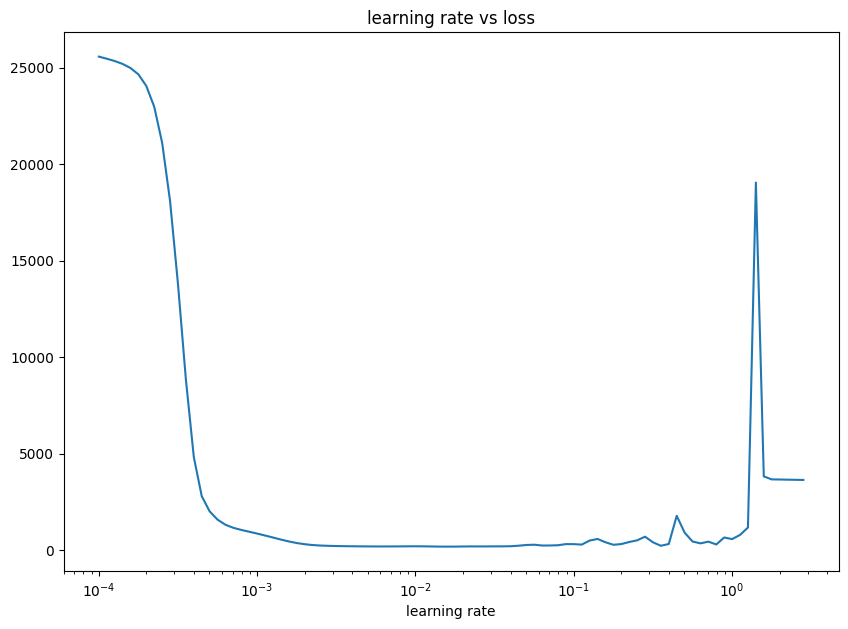

In [17]:
lrs = 1e-4*(10**(tf.range(90)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs,history.history["loss"])
plt.xlabel("learning rate")
plt.title("learning rate vs loss")